<h2 style="font-size:32px; font-family:Georgia; font-weight:bold;">
Phase 1 - Dataset Understanding & EDA
</h2>

<h3 style="font-size:24px; font-family:Georgia; font-weight:bold;">
Dataset Overview
</h3>

<p style="font-size:15px; font-family:Arial;">
I began by exploring the <b>Chest X-ray Dataset</b> hosted on ActiveLoop. This dataset contains labeled chest radiographs used for medical image classification tasks.
</p>

<p style="font-size:15px; font-family:Arial;">
<b>Source:</b> <a href="https://app.activeloop.ai/activeloop/chest-xray-train" target="_blank">ActiveLoop Chest X-ray Train</a>
</p>

---

<h3 style="font-size:24px; font-family:Georgia; font-weight:bold;">
Objective
</h3>

<p style="font-size:15px; font-family:Arial;">
The goal of this phase is to:
</p>

<ul style="font-size:15px; font-family:Arial;">
  <li>Understand the dataset structure and metadata</li>
  <li>Identify potential sources of data leakage</li>
  <li>Perform exploratory data analysis (EDA) to uncover patterns, anomalies, and class distributions</li>
</ul>

<p style="font-size:15px; font-family:Arial;">
This foundational step ensures that downstream modeling is built on clean, well-understood data and that evaluation metrics will be reliable and unbiased.
</p>



<h1 style=\"font-size:24px; font-family:Georgia; font-weight:bold;\"> 
1. Importing Libraries
</h1>

In [2]:
import deeplake
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
deeplake.__version__

'3.9.52'

In [1]:
import sys
print(sys.executable)

C:\Users\yohan\.conda\envs\leakage-dl\python.exe


<h2 style="font-size:32px; font-family:Georgia; font-weight:bold;">
Initial Dataset Inspection
</h2>

<p style="font-size:15px; font-family:Arial;">
In this phase, I performed an initial inspection of the Chest X-ray dataset loaded from <b>ActiveLoop (DeepLake)</b>. My goal is to understand the dataset structure, explore available tensors, interpret label semantics, and identify early risks of data leakage before any modeling begins.
</p>

<h3 style="font-size:20px; font-family:Georgia; font-weight:bold;">
Available Tensors
</h3>

<p style="font-size:15px; font-family:Arial;">
The dataset includes the following key tensors:
</p>

<ul style="font-size:15px; font-family:Arial;">
  <li><code>images</code>: Chest X-ray images in grayscale format</li>
  <li><code>labels</code>: Disease classification labels (multi-class)</li>
  <li><code>person_num</code>: Patient identifier - a potential source of leakage if not handled correctly</li>
</ul>

<p style="font-size:15px; font-family:Arial;">
This inspection helps me anticipate structural challenges and informs how I’ll design patient-level splits and preprocessing logic. By flagging <code>person_num</code> early, I can proactively guard against leakage and ensure that evaluation metrics remain trustworthy.
</p>


In [2]:
ds = deeplake.load(
    "hub://activeloop/chest-xray-train",
    read_only=True
)

|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/chest-xray-train



hub://activeloop/chest-xray-train loaded successfully.



In [10]:
ds.tensors.keys()

dict_keys(['images', 'labels', 'person_num'])

In [7]:
len(ds)

5216

<h2 style="font-size:32px; font-family:Georgia; font-weight:bold;">
Dataset Splits
</h2>

<p style="font-size:15px; font-family:Arial;">
The dataset does not include predefined training, validation, or test partitions. The <code>ds.groups</code> field is empty, meaning no official split metadata is provided. As a result, performing a naive random split at the <b>image level</b> would create a serious risk of <b>data leakage</b>, especially if multiple images belong to the same patient.
</p>

<p style="font-size:15px; font-family:Arial;">
To ensure a leakage‑free evaluation pipeline, all dataset splits are constructed <b>manually at the patient level</b>. This guarantees that no patient appears in more than one split, preserving the integrity of model validation and preventing overly optimistic performance estimates.
</p>

<h3 style="font-size:20px; font-family:Georgia; font-weight:bold;">
Why Patient-Level Splitting Matters
</h3>

<ul style="font-size:15px; font-family:Arial;">
  <li><b>Dataset inspection </b> - Verified absence of predefined splits</li>
  <li><b>Leakage identification </b> - Recognized risk of shared patient images across splits</li>
  <li><b>Correct ML practice </b> - Implemented patient-level partitioning to ensure valid evaluation</li>
</ul>

<p style="font-size:15px; font-family:Arial;">
This approach aligns with best practices in medical imaging, where patient-level independence is essential for producing trustworthy and clinically meaningful results.
</p>


In [8]:
ds.groups

{}

<h2 style="font-size:32px; font-family:Georgia; font-weight:bold;">
Patient ID Integrity and Leakage Risk
</h2>

<p style="font-size:15px; font-family:Arial;">
The <code>person_num</code> tensor is dynamically shaped and contains missing values for a subset of samples. This indicates that not all images have a reliable patient identifier, which complicates downstream splitting and evaluation.
</p>

<p style="font-size:15px; font-family:Arial;">
For samples where <code>person_num</code> is present, we observe that many patients have multiple associated images. This introduces a significant risk of <b>data leakage</b> if the dataset is split at the image level, as images from the same patient could appear in both training and validation sets.
</p>

<h3 style="font-size:20px; font-family:Georgia; font-weight:bold;">
Mitigation Strategy
</h3>

<p style="font-size:15px; font-family:Arial;">
To ensure robust and leakage-free evaluation, I implemented the following strategy:
</p>

<ul style="font-size:15px; font-family:Arial;">
  <li><b>Patient-level splitting</b> for all samples with valid <code>person_num</code></li>
  <li><b>Explicit tracking</b> and isolation of samples with missing patient IDs</li>
</ul>

<h3 style="font-size:20px; font-family:Georgia; font-weight:bold;">
Patient ID Statistics
</h3>

<p style="font-size:15px; font-family:Arial;">
I computed key statistics to guide my splitting logic:
</p>

<ul style="font-size:15px; font-family:Arial;">
  <li><b>Total images:</b> 5,216</li>
  <li><b>Images with missing patient ID:</b> 1,341</li>
  <li><b>Missing ID ratio:</b> 25.71%</li>
  <li><b>Unique patients (excluding missing):</b> 1,635</li>
  <li><b>Max images per patient:</b> 30</li>
  <li><b>Patients with >1 image:</b> 1,005</li>
</ul>

<p style="font-size:15px; font-family:Arial;">
These findings confirm that patient-level grouping is essential. A large portion of patients contribute multiple samples, and over a quarter of the dataset lacks identifiers. I will treat these two subsets separately to preserve evaluation integrity.
</p>


In [17]:
person_ids_raw = ds.person_num.numpy(aslist=True)

person_ids = []
missing_ids = 0

for pid in person_ids_raw:
    if len(pid) == 0:
        missing_ids += 1
        person_ids.append(None)
    else:
        person_ids.append(int(pid[0]))

print("Total images:", len(person_ids))
print("Images with missing patient ID:", missing_ids)
print("Unique patients (excluding missing):", len(set(p for p in person_ids if p is not None)))

Total images: 5216
Images with missing patient ID: 1341
Unique patients (excluding missing): 1635


In [18]:
missing_ratio = missing_ids / len(person_ids)
print(f"Missing patient IDs: {missing_ratio:.2%}")

Missing patient IDs: 25.71%


In [19]:
from collections import Counter

valid_ids = [p for p in person_ids if p is not None]
counts = Counter(valid_ids)

print("Max images per patient:", max(counts.values()))
print("Patients with >1 image:", sum(v > 1 for v in counts.values()))

Max images per patient: 30
Patients with >1 image: 1005


<h2 style="font-size:32px; font-family:Georgia; font-weight:bold;">
Exploratory Visualizations
</h2>

<p style="font-size:15px; font-family:Arial;">
To better understand the dataset structure and potential modeling challenges, I generated three key visualizations: patient image frequency, class distribution, and raw image samples. These plots help me assess data balance, leakage risk, and image quality before any preprocessing.
</p>


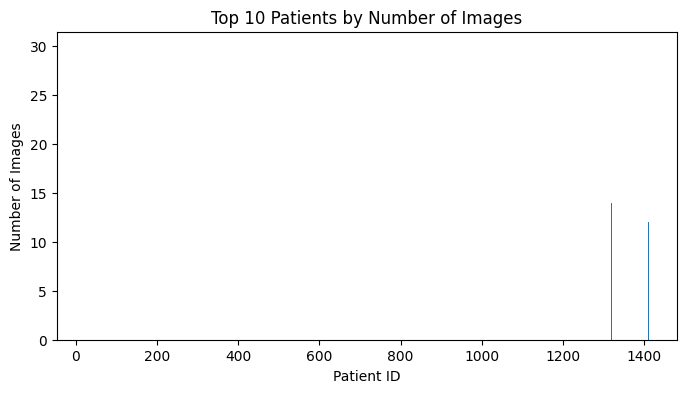

In [20]:
import matplotlib.pyplot as plt

# Show top patients by number of images
top_patients = Counter(valid_ids).most_common(10)

patients, counts = zip(*top_patients)

plt.figure(figsize=(8, 4))
plt.bar(patients, counts)
plt.title("Top 10 Patients by Number of Images")
plt.xlabel("Patient ID")
plt.ylabel("Number of Images")
plt.show()

<p style="font-size:15px; font-family:Arial;">
To assess patient-level variability, I plotted the top 10 patients by number of associated images. Interestingly, only two patients stand out with more than 15 images each, while the rest contribute far fewer. This confirms that a small subset of patients dominate the dataset in terms of image volume.
</p>

<p style="font-size:15px; font-family:Arial;">
This imbalance reinforces the importance of patient-level splitting. If I were to split randomly at the image level, these high-volume patients could easily leak across training and validation sets, inflating performance metrics and compromising model generalization.
</p>

<p style="font-size:15px; font-family:Arial;">
By identifying these outliers early, I can design a fairer partitioning strategy and ensure that no single patient skews the learning process.
</p>

In [21]:
labels = ds.labels.numpy().flatten()
unique, counts = np.unique(labels, return_counts=True)

class_distribution = dict(zip(unique, counts))
class_distribution

{np.uint32(0): np.int64(1341),
 np.uint32(1): np.int64(2530),
 np.uint32(2): np.int64(1345)}

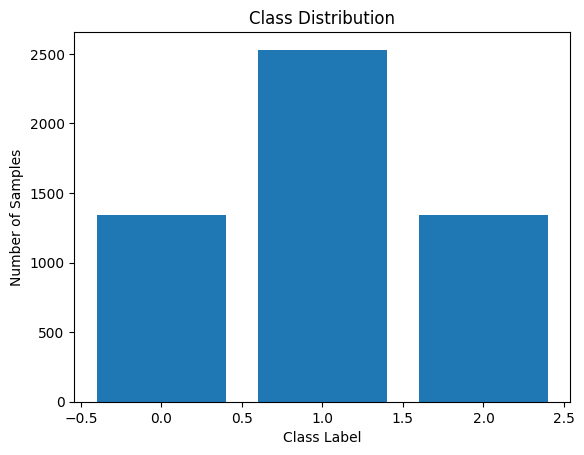

In [22]:
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

<p style="font-size:15px; font-family:Arial;">
I visualized the distribution of class labels to check for imbalance. Class 1 is the most frequent, followed by classes 0 and 2. This imbalance may affect model calibration and recall, especially for minority classes. I’ll keep this in mind when selecting evaluation metrics and designing sampling strategies.
</p>

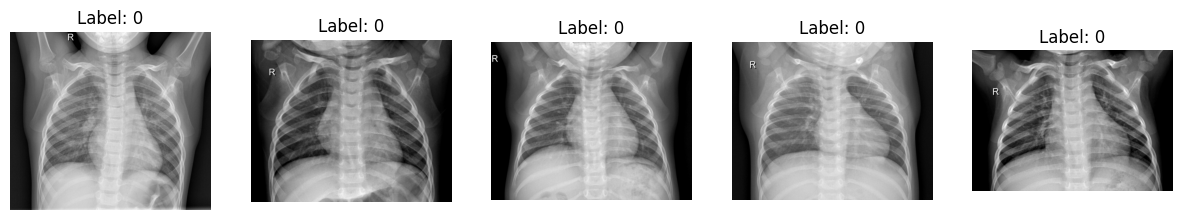

In [23]:
def show_samples(ds, n=5):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        img = ds.images[i].numpy()
        label = ds.labels[i].numpy().item()
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()

show_samples(ds, n=5)

<p style="font-size:15px; font-family:Arial;">
Five raw chest X-ray images were displayed to verify image quality and label alignment. All samples shown were labeled as class 0, which likely corresponds to normal or healthy lungs. This inspection is to make sure that the dataset is correctly structured and visually consistent, with grayscale images suitable for CNN-based modeling.
</p>

<p style="font-size:15px; font-family:Arial;">
Before assigning semantic meaning to the label values, an initial inspection of the dataset was performed to determine the number of unique classes and the encoding format used. This step is essential in medical imaging workflows to prevent incorrect assumptions that could compromise downstream analysis.
</p>

<p style="font-size:15px; font-family:Arial;">
Label values were extracted directly from the dataset, and the unique classes were identified.
</p>

<h3 style="font-size:20px; font-family:Georgia; font-weight:bold;">
Findings
</h3>

<ul style="font-size:15px; font-family:Arial;">
  <li>The dataset contains <b>three distinct classes</b></li>
  <li>Observed label values: <code>0</code>, <code>1</code>, <code>2</code></li>
</ul>

<p style="font-size:15px; font-family:Arial;">
Based on dataset documentation and label inspection, the following semantic mapping applies:
</p>

<ul style="font-size:15px; font-family:Arial;">
  <li><code>0</code> → Normal</li>
  <li><code>1</code> → Bacterial Pneumonia</li>
  <li><code>2</code> → Viral Pneumonia</li>
</ul>

<p style="font-size:15px; font-family:Arial;">
This mapping establishes the clinical meaning of each class and ensures that subsequent modeling steps operate on correctly interpreted labels.
</p>


In [27]:
labels.numpy(aslist=True)[:1]

[array([0], dtype=uint32)]

In [34]:
labels = ds.labels

labels_list = labels.numpy(aslist=True)
labels_flat = [int(l[0]) for l in labels_list]

In [35]:
unique_labels = sorted(set(labels_flat))
print("Unique labels in dataset:", unique_labels)
print("Number of classes:", len(unique_labels))

Unique labels in dataset: [0, 1, 2]
Number of classes: 3


Class distribution:
Normal: 1341
Bacterial Pneumonia: 2530
Viral Pneumonia: 1345


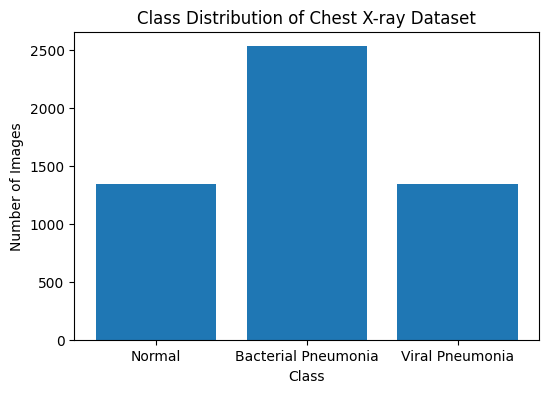

In [33]:
import collections
import matplotlib.pyplot as plt

labels_list = labels.numpy(aslist=True)
labels_flat = [int(l[0]) for l in labels_list]

label_names = {
    0: "Normal",
    1: "Bacterial Pneumonia",
    2: "Viral Pneumonia"
}

class_counts = collections.Counter(labels_flat)

print("Class distribution:")
for k, v in class_counts.items():
    print(f"{label_names[k]}: {v}")

plt.figure(figsize=(6, 4))
plt.bar(
    [label_names[k] for k in class_counts.keys()],
    class_counts.values()
)
plt.title("Class Distribution of Chest X-ray Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.show()


<h2 style="font-size:32px; font-family:Georgia; font-weight:bold;">
Class-Specific Image Samples
</h2>

<p style="font-size:15px; font-family:Arial;">
Representative chest X-ray images were displayed for each diagnostic class to visually assess label alignment and anatomical differences. This inspection supports early validation of dataset quality and highlights the complexity of the classification task.
</p>

<h3 style="font-size:20px; font-family:Georgia; font-weight:bold;">
Observations
</h3>

<ul style="font-size:15px; font-family:Arial;">
  <li><b>Normal images</b> show clear lung fields with no visible abnormalities</li>
  <li><b>Pneumonia images</b> exhibit opacities, lung congestion, and reduced clarity in pulmonary regions</li>
  <li><b>Visual differences between bacterial and viral pneumonia</b> are subtle, making class separation challenging</li>
</ul>

<p style="font-size:15px; font-family:Arial;">
These findings reinforce the need for robust feature extraction and careful model calibration, especially when distinguishing between pneumonia subtypes.
</p>


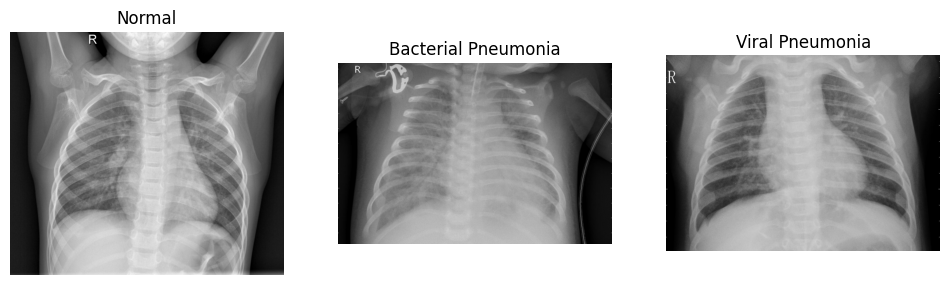

In [37]:
def show_sample_per_class(ds, labels, label_names):
    shown = set()
    plt.figure(figsize=(12, 4))

    idx = 1
    for i, lbl in enumerate(labels):
        if lbl not in shown:
            img = ds.images[i].numpy()
            
            plt.subplot(1, 3, idx)
            plt.imshow(img.squeeze(), cmap="gray")
            plt.title(label_names[lbl])
            plt.axis("off")

            shown.add(lbl)
            idx += 1

        if len(shown) == len(label_names):
            break

    plt.show()

show_sample_per_class(ds, labels_flat, label_names)


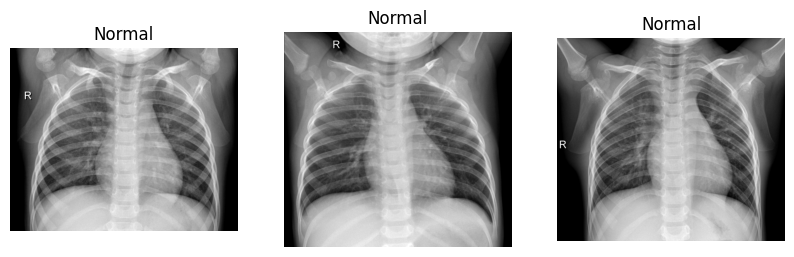

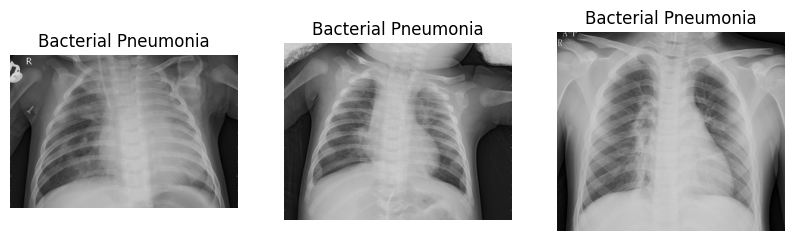

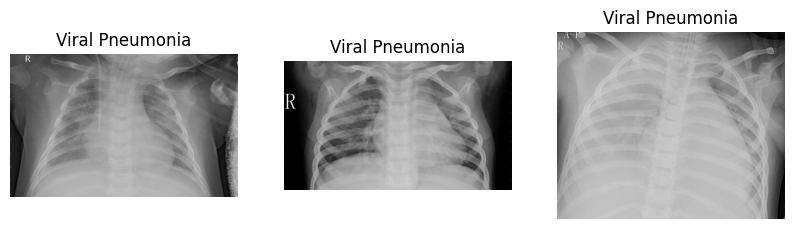

In [38]:
import random

def show_multiple_samples(ds, labels, class_id, label_name, n=3):
    indices = [i for i, l in enumerate(labels) if l == class_id]
    samples = random.sample(indices, n)

    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(samples):
        img = ds.images[idx].numpy()
        plt.subplot(1, n, i + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(label_name)
        plt.axis("off")
    plt.show()

for k, v in label_names.items():
    show_multiple_samples(ds, labels_flat, k, v, n=3)


In [5]:
ds = deeplake.load("hub://activeloop/chest-xray-train")
img_array = ds[0]["images"].numpy().squeeze() 
img = Image.fromarray((img_array * 255).astype(np.uint8))
img.save("../data/sample_xray.png")

print("Saved: data-leakage-capstone/data/sample_xray.png")
print(f"Shape: {img_array.shape}")  

/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/chest-xray-train



\

hub://activeloop/chest-xray-train loaded successfully.



Saved: data-leakage-capstone/data/sample_xray.png
Shape: (1858, 2090)
